## Chapter Goals

* Use walkforward analysis to evaluate GMM prediction accuracy
* Design an event study
* Use results to determine if any tradeable patterns exist

## Chapter Outline

    1. Use GMM to predict return distribution
    2. Evaluate GMM accuracy in predicting confidence intervals
    3. Design and implement an event study based on post "outlier" returns
    4. Evaluate Event Study
    5. Conclusions

In [1]:
%load_ext watermark
%watermark

from IPython.display import display

# import standard libs
from pathlib import PurePath, Path
import sys
import time
from itertools import count

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'scripts' 
viz_dir = pdir / 'visuals' / '03_Strategy_Research'
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
savefig_kwds = dict(dpi=300, bbox_inches='tight')
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from utils import cprint, make_gmm, make_ic_series

# set plot globals
plt.style.use('bmh') 
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,8

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,mizani,pyarrow

2017-12-15T14:43:33-07:00

CPython 3.6.3
IPython 6.2.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.0-101-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/media/files/anaconda3/envs/bayesian/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pandas 0.21.0
pandas_datareader 0.5.0
numpy 1.13.3
sklearn 0.19.1
statsmodels 0.8.0
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
plotnine 0.3.0+13.gf58573d
mizani 0.4.2
pyarrow 0.7.1


## 1. Using GMMs to Predict Return Distributions

In this section we will implement a GMM to iteratively predict the distribution for our lookahead period. To do this we will make sure of `sklearn's` `TimeSeriesSplit()` function, which increments train/test data sets sequentially. This is to avoid the loss of autocorrelation information caused by using traditional cross validation techniques, which assume that the data is [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). 

First we load the dataset.

In [2]:
load_parquet = lambda fp: (pq.read_table(fp).to_pandas().assign(year=lambda df: df.index.year).loc['2005':])

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = load_parquet(load_fp)
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 EEM       EFA       GLD       QQQ       SPY       TLT  year
Date                                                                        
2017-09-25 -0.017113 -0.005719  0.010413 -0.010588 -0.002047  0.006240  2017
2017-09-26 -0.002694 -0.002208 -0.011225  0.002588  0.000602 -0.001813  2017
2017-09-27 -0.003603  0.000737 -0.009465  0.008970  0.003887 -0.015183  2017
2017-09-28 -0.000677  0.002647  0.001884 -0.000346  0.001199 -0.002968  2017
2017-09-29  0.011447  0.005858 -0.005168  0.007176  0.003509  0.002247  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 7 columns):
EEM     3209 non-null float64
EFA     3209 non-null float64
GLD     3209 non-null float64
QQQ     3209 n

Next we choose the example symbol's returns.

In [3]:
sym = 'SPY' # example symbol
s = rdf[sym].copy() 
s.to_frame().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 1 columns):
SPY    3209 non-null float64
dtypes: float64(1)
memory usage: 50.1 KB


Now we can run the walkforward analysis. The next cell implements the `TimeSeriesSplit` method from `sklearn`. Essentially we iterate over each day using the previous data to estimate the model parameters and make a prediction about the next day's return distribution. We save the key prediction information and results each day and then combine that into a `df` for easy analysis. In this example we will baseline our study by using a single mixture component.

*I have heavily commented the code below if you are interested in more details.*

In [4]:
%%time

np.random.seed(0)

lookback = 252 * 1
n_components = 1 # baseline
n_split = len(s) - 1 # since we are iterating daily we need 1 less than total series for splits

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.95 # for sampling confidence intervals
pred_rows = [] # init list to hold df rows
c = count(1) # init counter

for i, (train, test) in enumerate(tscv.split(s)):
    if next(c) < lookback: # add training data until min lookback
        continue

    ### set up train/test data ###
    # temp train data as pd.Series
    tmp_train = s.iloc[train]
    X_train = tmp_train.reshape(-1, 1) # must reshape for sklearn
    # temp test data as pd.Series
    #  returns pd.Series with shape (1,)
    tmp_test = s.iloc[test]
    X_test = tmp_test.reshape(1, -1) # must reshape
    
    ### fit GMM ###
    gmm = make_gmm(n_components).fit(X_train)
    hidden_states = gmm.predict(X_train) # extract hidden states
    
    ### get last state estimate ###
    last_state = hidden_states[-1]
    last_mean = gmm.means_[last_state]
    last_var = np.diag(gmm.covariances_[last_state])
    
    ### sample from distribution using last state parameters ###
    # must choose number of samples
    n_samples = 1000
    rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
    low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))
    
    ### store data into rows ###
    # columns: cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
    pred_rows.append((tmp_test.index[0], last_state, last_mean[0], last_var[0], 
                      low_ci, high_ci, X_test.ravel()[0]))    

CPU times: user 4min 2s, sys: 8 ms, total: 4min 2s
Wall time: 4min 2s


Next we create the dataframe to hold the prediction information. In this step we also add the accuracy information about whether the actual return fell within our predicted interval.

In [5]:
def in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

### make prediction df ###
cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
pred_df = (pd.DataFrame(pred_rows, columns=cols)
           .pipe(in_range))

cprint(pred_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
          Dates  ith_state   ith_ret   ith_var    low_ci   high_ci  \
2952 2017-09-25          0  0.000629  0.000024 -0.009297  0.010088   
2953 2017-09-26          0  0.000643  0.000024 -0.009185  0.010458   
2954 2017-09-27          0  0.000677  0.000024 -0.008807  0.009821   
2955 2017-09-28          0  0.000668  0.000024 -0.008960  0.009801   
2956 2017-09-29          0  0.000653  0.000024 -0.008802  0.010034   

      actual_return  in_range  
2952      -0.002047         1  
2953       0.000602         1  
2954       0.003887         1  
2955       0.001199         1  
2956       0.003509         1  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2957 entries, 0 to 2956
Data columns (total 8 columns):
Dates            2957 non-null datetime64[ns]
it

## 2. Evaluate GMM accuracy in predicting confidence intervals

Now we can plot the output and assess the accuracy of the distribution predictions.

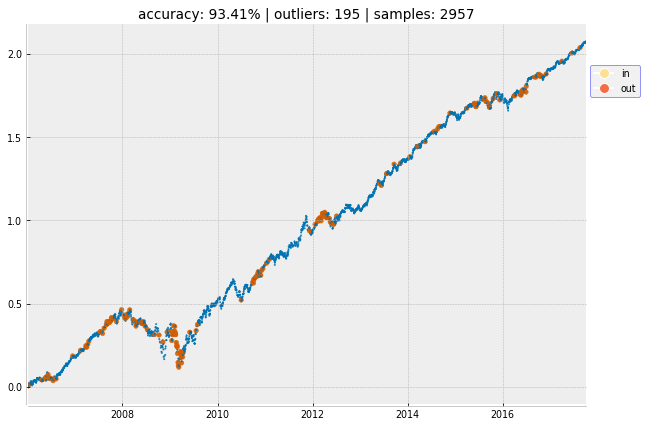

In [6]:
def plot_cuml_preds(pred_df):
    df = pred_df.set_index('Dates')
    n = df.shape[0]
    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / n
    
    colors = sns.color_palette('RdYlBu', 4)
    fig, ax = plt.subplots(figsize=(10, 7))
    marker_size = [2 if x==1 else 20 for x in df['in_range']]
    alpha_list = [0.25 if x==1 else .9 for x in df['in_range']]
    ax.scatter(df.query('in_range==1').index, df.query('in_range==1')['actual_return'].cumsum(),
               alpha=.9, s=marker_size,
               c=[blue if x == 1 else red for x in df['in_range']])

    ax.set_xlim(df.index[0], df.index[-1])

    ax.set_title(f'accuracy: {accuracy:2.2%} | outliers: {n-nRight} | samples: {n}')

    win_kwds = dict(color="white", marker='o', markersize=10)
    in_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[1], **win_kwds)
    out_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[0], **win_kwds)
    ci_kwds = dict(color="white", marker='.', markersize=10)
    leg = ax.legend([in_, out_], ["in", "out"],
                    loc="center left", bbox_to_anchor=(1, 0.85), numpoints=1)
    leg.get_frame().set_edgecolor('blue')
    sns.despine(offset=2)
    return 
    
    
### plot ###
from pandas.tseries import converter
converter.register()

plot_cuml_preds(pred_df)
plt.savefig(PurePath(viz_dir / f'{sym}_cuml_returns_outliers_ex.png').as_posix(), **savefig_kwds)

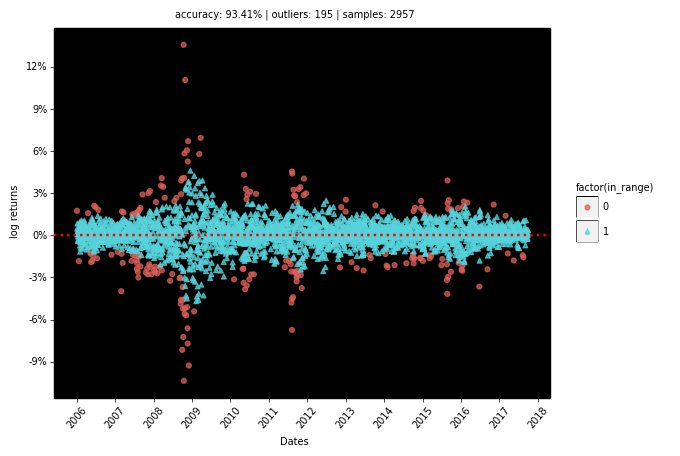

<ggplot: (8748844640737)>


In [7]:
def plot_distr_accuracy(df, state_col=None):
    n = df.shape[0]
    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / n
    
    g = (pn.ggplot(df, pn.aes(x='Dates',y='actual_return', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'), alpha=0.75)
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(df['actual_return'].min(), df['actual_return'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 years'),
                               labels=mzf.date_format('%Y'))         
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('log returns')
         + pn.ggtitle(f'accuracy: {accuracy:2.2%} | outliers: {n-nRight} | samples: {n}'))
    return g

### plot ###
g = plot_distr_accuracy(pred_df, 'in_range')
print(g)
g.save(PurePath(viz_dir / f'{sym}_scatter_returns_outliers_ex.png').as_posix(), **savefig_kwds)

Naturally one may be curious how many outliers there were per period _(year, month)_ for the purposes of ascertaining how many potential trading opportunities there are assuming a trade can be entered at each outlier point.

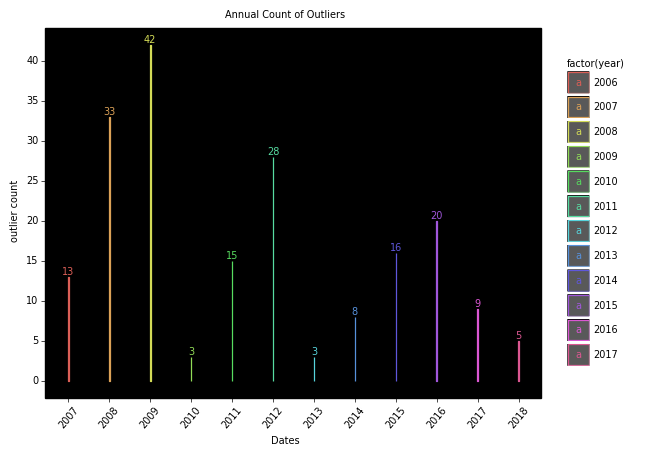

<ggplot: (-9223363288011908422)>


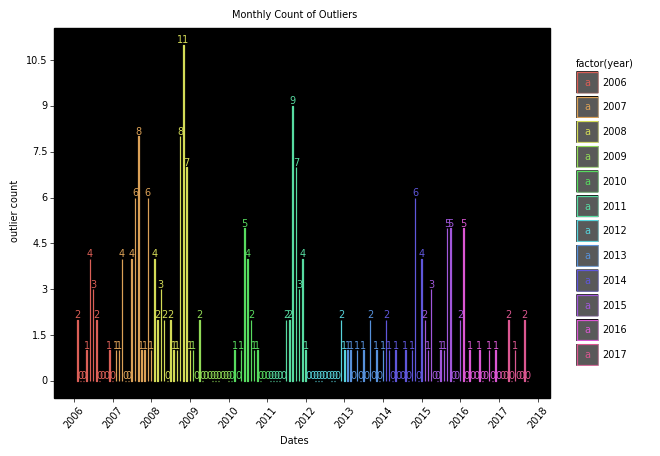

<ggplot: (8748842873569)>


In [8]:
def plot_outliers_bar(pred_df, period='A'):
    grp = pred_df.set_index('Dates').groupby([pd.TimeGrouper(period)])['in_range']  
    df = ((grp.count() - grp.sum())
          .reset_index()
          .rename(columns={'in_range':'outliers'})
          .assign(year=lambda df: df['Dates'].dt.year))

    period_map = dict(A='Annual', M='Monthly')
    dodge_text = pn.position_dodge(width=0.9)
    g = (pn.ggplot(df, pn.aes(x='Dates', y='outliers', color='factor(year)'))
         + pn.geom_bar(stat='identity', width=5.)#, position=pn.position_dodge(width=1))
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 limits=(0, df['outliers'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 year'),
                               labels=mzf.date_format('%Y'),)
         + pn.geom_text(pn.aes(label='outliers'),
                        position=dodge_text,
                        size=7, va='bottom')
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('outlier count')
         + pn.ggtitle(f'{period_map[period]} Count of Outliers'))
    return g

### plot ###
g = plot_outliers_bar(pred_df, period='A')
g1 = plot_outliers_bar(pred_df, period='M')

g.save(PurePath(viz_dir / f'{sym}_outliers_per_annual_ex.png').as_posix(), **savefig_kwds)
g1.save(PurePath(viz_dir / f'{sym}_outliers_per_month_ex.png').as_posix(), **savefig_kwds)

print(g)
print(g1)

Let's bundle the functions under a wrapper function so we can run the same analysis with different symbols and different study parameters.

In [9]:
def _in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

def _make_pred_df(pred_rows):
    """fn: make pred df after walkforward"""
    cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
    pred_df = (pd.DataFrame(pred_rows, columns=cols)
               .pipe(_in_range))
    return pred_df

def walkforward(ts, tscv, n_components, alpha):
    """fn: implements walkforward cross validation on a single timeseries
            to predict the distribution of returns 1 step ahead
    # args
        ts : pd.Series(), index='Dates', values=symbol
        tscv : sklearn TimeSeriesSplit Object
        n_components : int(), number of Gaussian distributions to fit to data
        alpha : float(), between 0,1 for sampling confidence intervals
        
    """
    pred_rows = [] # init list to hold df rows
    c = count(1) # init counter
    for i, (train, test) in enumerate(tscv.split(s)):
        if next(c) < lookback: # add training data until min lookback
            continue

        ### set up train/test data ###
        # temp train data as pd.Series
        tmp_train = s.iloc[train]
        X_train = tmp_train.reshape(-1, 1) # must reshape for sklearn
        # temp test data as pd.Series
        #  returns pd.Series with shape (1,)
        tmp_test = s.iloc[test]
        X_test = tmp_test.reshape(1, -1) # must reshape

        ### fit GMM ###
        gmm = make_gmm(n_components).fit(X_train)
        hidden_states = gmm.predict(X_train) # extract hidden states

        ### get last state estimate ###
        last_state = hidden_states[-1]
        last_mean = gmm.means_[last_state]
        last_var = np.diag(gmm.covariances_[last_state])

        ### sample from distribution using last state parameters ###
        # must choose number of samples
        n_samples = 1000
        rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
        low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))

        ### store data into rows ###
        # columns: cols = ['Dates', 'ith_state', 'ith_ret','ith_var', 'low_ci', 'high_ci', 'actual_return']
        pred_rows.append((tmp_test.index[0], last_state, last_mean[0], last_var[0], 
                          low_ci, high_ci, X_test.ravel()[0]))    
        
    pred_df = _make_pred_df(pred_rows)
    return pred_df

### plot ###

def plot_all(pred_df):
    plot_cuml_preds(pred_df)
    g = plot_distr_accuracy(pred_df, 'in_range')
    g1 = plot_outliers_bar(pred_df, period='A')
    g2 = plot_outliers_bar(pred_df, period='M')
    
    g.save(PurePath(viz_dir / f'{sym}_scatter_returns_outliers.png').as_posix(), **savefig_kwds)
    g1.save(PurePath(viz_dir / f'{sym}_outliers_per_annual.png').as_posix(), **savefig_kwds)
    g2.save(PurePath(viz_dir / f'{sym}_outliers_per_month.png').as_posix(), **savefig_kwds)    

    print(g)
    print(g1)
    print(g2)

In this section we compute the optimal number of components using the `aic` and `bic`. Here we will default to `bic` to lessen the computational burden.

CPU times: user 5min 57s, sys: 13min 42s, total: 19min 39s
Wall time: 2min 39s


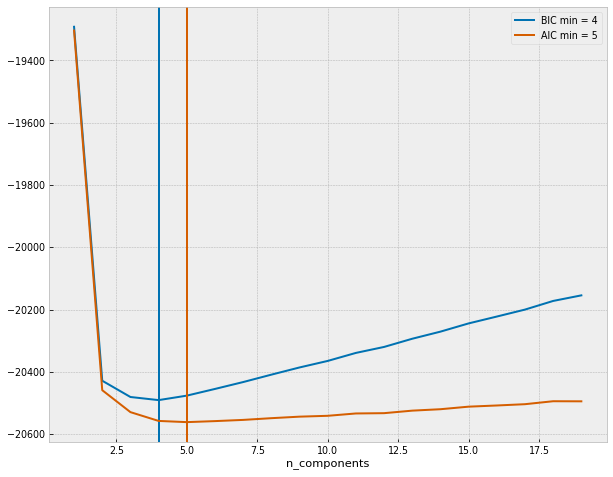

In [10]:
%%time

np.random.seed(0)

_X = s.reshape(-1, 1)

n_components = np.arange(1,20)
aics = []
bics = []

for n in n_components:
    tmp_gmm = make_gmm(n, 150).fit(_X)
    aics.append((n, tmp_gmm.aic(_X)))
    bics.append((n, tmp_gmm.bic(_X)))

bics = make_ic_series(bics, 'bic')
aics = make_ic_series(aics, 'aic')
    
bic_optimal_n = np.argmin(bics)
aic_optimal_n = np.argmin(aics)
    
plt.plot(n_components, bics.values, color=blue, label=f'BIC min = {bic_optimal_n}')
plt.axvline(np.argmin(bics), color=blue)

plt.plot(n_components, aics.values, color=red, label=f'AIC min = {aic_optimal_n}')
plt.axvline(np.argmin(aics), color=red)

plt.legend(loc='best')
plt.xlabel('n_components');
plt.savefig(PurePath(viz_dir / f'{sym}_aic_bic_optimal_choice.png').as_posix(), **savefig_kwds)

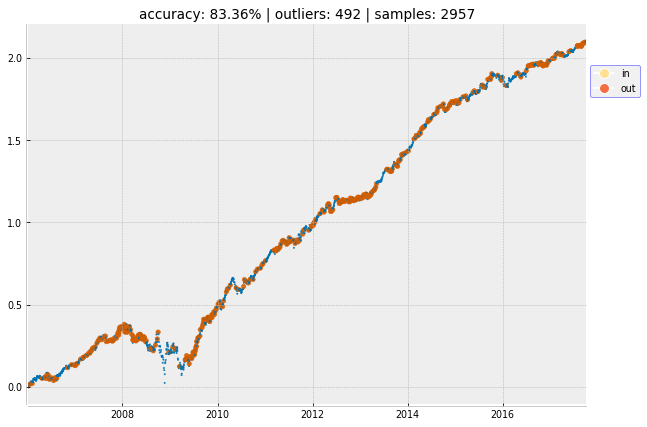

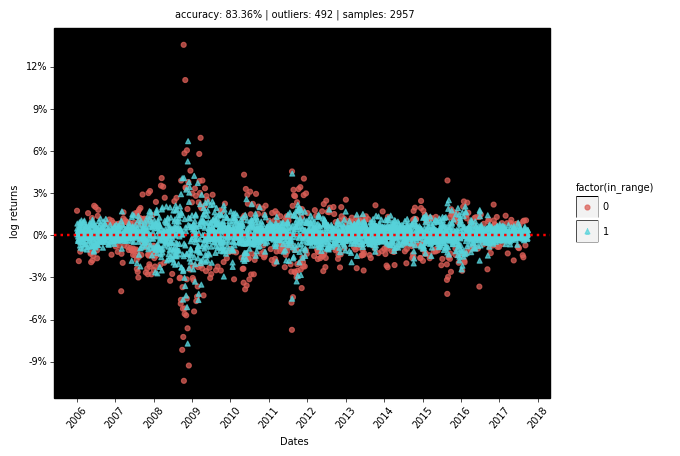

<ggplot: (-9223363288011827761)>


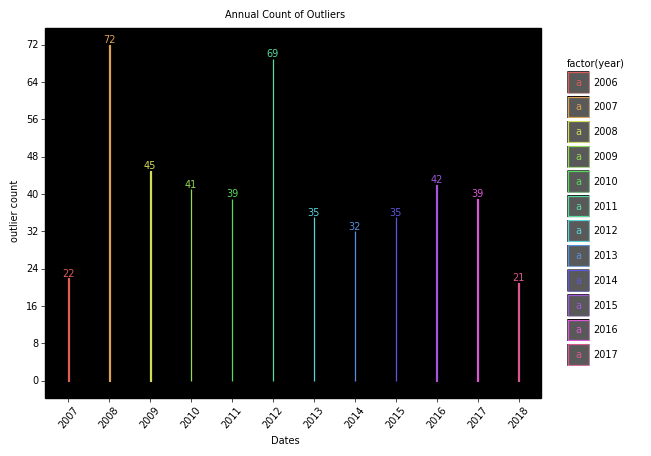

<ggplot: (-9223363288011893844)>


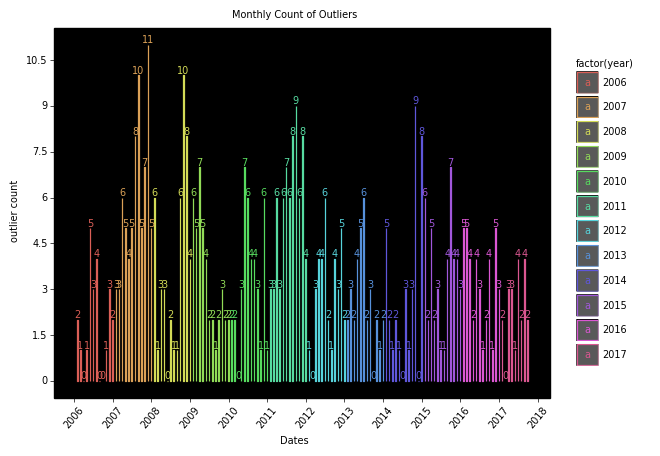

<ggplot: (-9223363288010186850)>
CPU times: user 28min 49s, sys: 4.54 s, total: 28min 54s
Wall time: 28min 48s


In [11]:
%%time

np.random.seed(0)

lookback = 252 * 1
n_components = bic_optimal_n # experiment
n_split = (len(s) - 1) #

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.95 # for sampling confidence intervals

pred_df = walkforward(s, tscv, n_components, alpha)
plot_all(pred_df)

Very interesting that the accuracy of the return distribution prediction is better with less components. Although one could reason that with multiple distributions, when the incorrect component parameters are used to seed the distribution sampling that the errors/outliers can be compounded, but then what would be the purpose of using a "mixture" at all? Let's see if the event study can add clarity to this question.

## 3. Design and implement an event study based on post outlier returns

In the next section we add information about the direction of the outlier e.g. was it `too_high` or `too_low`

In [12]:
## build event study to determine the effects of the number of components in terms of returns post event

def get_outlier_direction(df):
    """"""
    direction = []
    for row in df[['high_ci', 'actual_return']].itertuples(index=False):
        if row[-1] > row[0]: # actual_returns > high_ci
            direction.append('too_high')
        else: 
            direction.append('too_low')
    df = df.assign(direction=direction)
    return df

## make outliers ##
outliers = (pred_df.query('in_range==0').pipe(get_outlier_direction))
outliers.head()

,Dates,ith_state,ith_ret,ith_var,low_ci,high_ci,actual_return,in_range,direction
0,2006-01-03,0,-0.000176,0.000045,-0.013411,0.012453,0.017436,0,too_high
12,2006-01-20,2,0.000847,0.000036,-0.011317,0.012608,-0.018406,0,too_low
21,2006-02-02,3,0.000914,0.000037,-0.010503,0.012601,-0.011673,0,too_low
72,2006-04-18,3,0.001206,0.000033,-0.009801,0.012024,0.015732,0,too_high
89,2006-05-11,2,0.000657,0.000032,-0.010075,0.011750,-0.012145,0,too_low


In [13]:
def get_post_outlier_returns(df, lookahead, direction):
    """fn: accumulate post outlier cuml. returns"""
    trade_entry_dt = pd.Timedelta('1D') # assumes daily resolution
    post_event_returns = []
    for i in outliers.query(f'direction=="{direction}"')['Dates']:
        tmp_cml = pred_df.set_index('Dates').loc[i+trade_entry_dt:i+lookahead]['actual_return'].cumsum() 
        post_event_returns.append((i, tmp_cml.iloc[-1]))
    df = (pd.DataFrame(post_event_returns, 
                       columns=['Dates','cuml_returns']))
    return df

lookahead = pd.Timedelta('5 days')
too_high_returns = get_post_outlier_returns(pred_df, lookahead, 'too_high')
too_low_returns = get_post_outlier_returns(pred_df, lookahead, 'too_low')

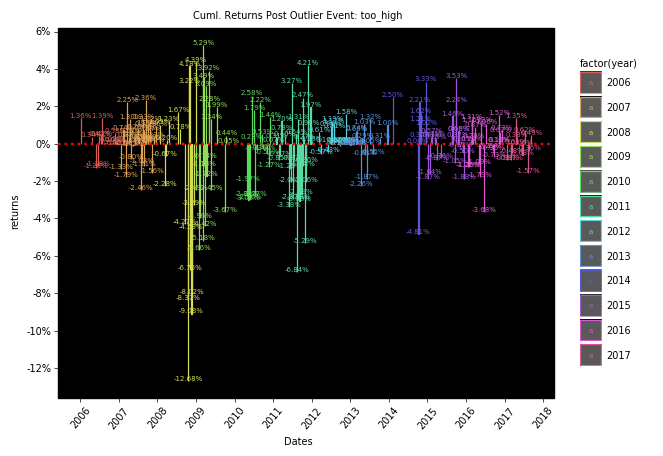

<ggplot: (8748842332564)>


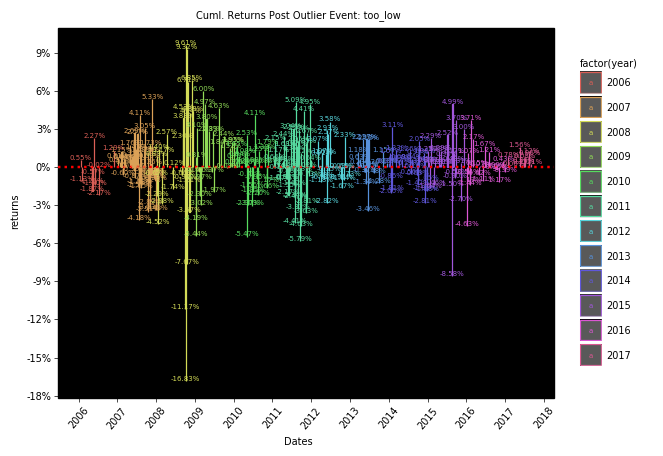

<ggplot: (8748842334924)>


In [14]:
def plot_post_outliers_bar(post_df, direction):
 
    df = (post_df.assign(year=lambda df: df['Dates'].dt.year))

    dodge_text = pn.position_dodge(width=0.9)
    g = (pn.ggplot(df, pn.aes(x='Dates', y='cuml_returns', color='factor(year)'))
         + pn.geom_bar(stat='identity')#, width=5.)#, position=pn.position_dodge(width=1))
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(df['cuml_returns'].min(), df['cuml_returns'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 year'),
                               labels=mzf.date_format('%Y'),)
         + pn.geom_text(pn.aes(label='cuml_returns'),
                        position=dodge_text,
                        size=5, va='bottom', format_string='{:.2%}')
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('returns')
         + pn.ggtitle(f'Cuml. Returns Post Outlier Event: {direction}'))
    return g

### plot ###
g = plot_post_outliers_bar(too_high_returns, 'too_high')
g1 = plot_post_outliers_bar(too_low_returns, 'too_low')

g.save(PurePath(viz_dir / f'{sym}_post_outliers_too_high.png').as_posix(), **savefig_kwds)
g1.save(PurePath(viz_dir / f'{sym}_post_outliers_too_low.png').as_posix(), **savefig_kwds) 

print(g); print(g1)

Note that in this event study, we assume a trade cannot be entered into until `1` day after the signal is generated. If you remove the `trade_entry_dt` within the `get_post_outlier_returns` function, the returns are much more favorable. See the example below:

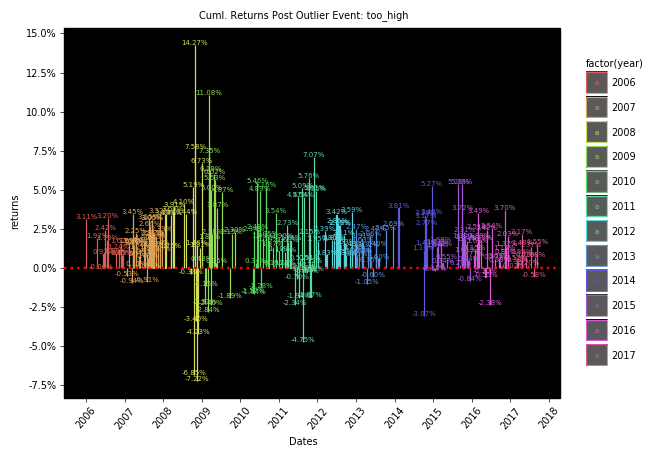

<ggplot: (8748842289416)>


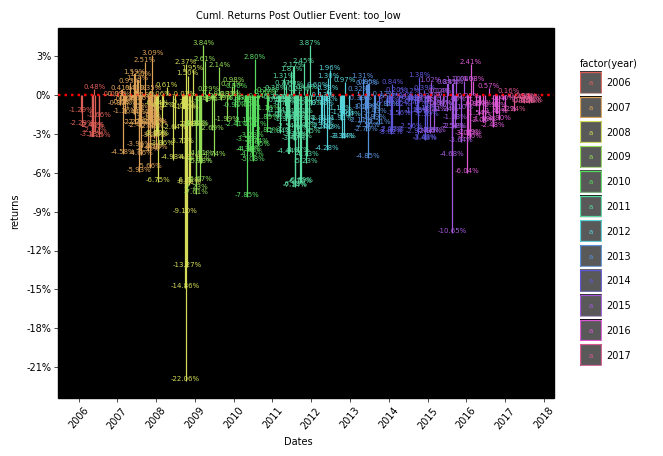

<ggplot: (8748842821489)>


In [15]:
def get_post_outlier_returns2(df, lookahead, direction):
    """fn: accumulate post outlier cuml. returns"""
    trade_entry_dt = pd.Timedelta('1D') # example with this removed 
    post_event_returns = []
    for i in outliers.query(f'direction=="{direction}"')['Dates']:
        #tmp_cml = pred_df.set_index('Dates').loc[i+trade_entry_dt:i+lookahead]['actual_return'].cumsum()
        tmp_cml = pred_df.set_index('Dates').loc[i:i+lookahead]['actual_return'].cumsum() 
        post_event_returns.append((i, tmp_cml.iloc[-1]))
    df = (pd.DataFrame(post_event_returns, 
                       columns=['Dates','cuml_returns']))
    return df

lookahead = pd.Timedelta('5 days')
### plot ###
g = plot_post_outliers_bar(get_post_outlier_returns2(pred_df, lookahead, 'too_high'), 'too_high')
g1 = plot_post_outliers_bar(get_post_outlier_returns2(pred_df, lookahead, 'too_low'), 'too_low')

g.save(PurePath(viz_dir / f'{sym}_post_outliers_too_high_no_dt.png').as_posix(), **savefig_kwds)
g1.save(PurePath(viz_dir / f'{sym}_post_outliers_too_low_no_dt.png').as_posix(), **savefig_kwds) 

print(g); print(g1)

*What is happening here?*

This is an indication that most of the trade gains occured overnight when the market is closed e.g. a gap up/down, or intraday, neither of which are captured by this event study. These types of issues require careful testing in the backtesting environment to really determine if a strategy can be implemented or if it really is just *theoretical*.

In [16]:
def sdescribe(df, sym, look, direction, post_2009=False):
    """fn: custom describe function for tracking results of event study
    
    # args
        df: pd.DataFrame()
        sym: str(), asset symbol
        look: pd.TimeDelta(), int(), float()
            lookahead period for computing forward returns
        direction: str(), ('too_low', 'too_high')
            outlier classification
        post_2009: bool(),
            flag indicating if returns are all inclusive or
            post 2009 only
    
    # returns
        t: pd.DataFrame()
    """
    t = df.describe().copy()
    t.loc['sum'] = df.sum().values[0]
    t.loc['median'] = df.median().values[0]
    t.loc['max_ratio'] = t.loc['max'].abs() / t.loc['min'].abs()
    t.loc['pct_neg'] = df.query('cuml_returns < 0').shape[0] / df.shape[0]
    t.loc['pct_pos'] = 1 - t.loc['pct_neg']
    t.loc['symbol'] = sym
    t.loc['lookahead'] = look
    t.loc['direction'] = direction
    t.loc['post_2009'] = post_2009
    return t

tl_args = (sym, lookahead, 'too_low'); th_args = (sym, lookahead, 'too_high')
display(sdescribe(too_low_returns, *tl_args)), display(sdescribe(too_high_returns, *th_args))

,cuml_returns
count,276
mean,0.00152045
std,0.0268314
min,-0.168287
25%,-0.0111423
50%,0.00238941
75%,0.0136862
max,0.0961116
sum,0.419645
median,0.00238941


,cuml_returns
count,216
mean,-0.00271081
std,0.0230569
min,-0.126831
25%,-0.0105997
50%,0.00115451
75%,0.00954981
max,0.0528925
sum,-0.585535
median,0.00115451


(None, None)

We can check the stability of returns post `2009` as well. Doing this gives a good indication of a couple things:

    * was the return pattern overly influenced by the previous period's high volatility?
    * was the return pattern only observed during the previous period?
    * were the largest gains/losses confined to the prior period?

In [17]:
display(sdescribe(too_low_returns.set_index('Dates').loc['2009':], *tl_args, post_2009=True)), display(sdescribe(too_high_returns.set_index('Dates').loc['2009':], *th_args, post_2009=True))

,cuml_returns
count,199
mean,0.00202199
std,0.0215318
min,-0.0858313
25%,-0.00962654
50%,0.00278126
75%,0.0134788
max,0.0599575
sum,0.402375
median,0.00278126


,cuml_returns
count,154
mean,-0.00158048
std,0.0194194
min,-0.0684483
25%,-0.0102767
50%,0.000843984
75%,0.00973948
max,0.0528925
sum,-0.243393
median,0.000843984


(None, None)

In [20]:
%%time

looks = [4,5,7,10,21,30,42,63,120]
res = list()

for l in looks:
    try:
        lookahead = pd.Timedelta(f'{l} days') # lookahead in days
        too_high_returns = get_post_outlier_returns(pred_df, lookahead, 'too_high')
        too_low_returns = get_post_outlier_returns(pred_df, lookahead, 'too_low')
        
        # make sdescribe args
        tl_args = (sym, lookahead, 'too_low'); th_args = (sym, lookahead, 'too_high')
        
        print('-'*50)
        print('all returns')
        print(f'## too low, lookahead = {l} ##')
        tl = sdescribe(too_low_returns, *tl_args)
        res.append(tl)
        #display(tl),
        print(f'## too high, lookahead = {l} ##')
        th = sdescribe(too_high_returns, *th_args)
        res.append(th)
        #display(th)
        
        print('-'*50)
        print('post 2009 returns')
        print(f'## post too low, lookahead = {l} ##')
        tl_10 = sdescribe(too_low_returns.set_index('Dates').loc['2010':], *tl_args, post_2009=True)
        #display(tl_10),
        res.append(tl_10)
        print(f'## post too high , lookahead = {l} ##')
        th_10 = sdescribe(too_high_returns.set_index('Dates').loc['2010':], *th_args, post_2009=True)
        #display(th_10)
        res.append(th_10)
    except Exception as e:
        print(e)

--------------------------------------------------
all returns
## too low, lookahead = 4 ##
## too high, lookahead = 4 ##
--------------------------------------------------
post 2009 returns
## post too low, lookahead = 4 ##
## post too high , lookahead = 4 ##
--------------------------------------------------
all returns
## too low, lookahead = 5 ##
## too high, lookahead = 5 ##
--------------------------------------------------
post 2009 returns
## post too low, lookahead = 5 ##
## post too high , lookahead = 5 ##
--------------------------------------------------
all returns
## too low, lookahead = 7 ##
## too high, lookahead = 7 ##
--------------------------------------------------
post 2009 returns
## post too low, lookahead = 7 ##
## post too high , lookahead = 7 ##
--------------------------------------------------
all returns
## too low, lookahead = 10 ##
## too high, lookahead = 10 ##
--------------------------------------------------
post 2009 returns
## post too low, lookahe

Below we combine the results into a `results_df` for easy storage and analysis.

In [28]:
results_df = (pd.concat(res, axis=1)
              .T
              .reset_index(drop=True)
              .convert_objects(convert_numeric=True))

results_df.to_csv(PurePath(pdir / 'data' / 'event_study_results.csv').as_posix(), index=False)
display(cprint(results_df)); display(results_df.nlargest(10, 'median'))

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
    count      mean       std       min       25%       50%       75%  \
31  135.0  0.018618  0.049091 -0.170181  0.004171  0.025655  0.046999   
32  276.0  0.026150  0.096837 -0.381686 -0.015090  0.043013  0.082643   
33  216.0  0.024277  0.094299 -0.379488 -0.014036  0.036102  0.080826   
34  177.0  0.046756  0.067127 -0.152748  0.018659  0.051529  0.090063   
35  135.0  0.041928  0.059253 -0.148279  0.016802  0.051569  0.079448   

         max       sum    median  max_ratio   pct_neg   pct_pos symbol  \
31  0.106033  2.513437  0.025655   0.623060  0.222222  0.777778    SPY   
32  0.229694  7.217331  0.043013   0.601788  0.278986  0.721014    SPY   
33  0.237552  5.243853  0.036102   0.625982  0.282407  0.717593    SPY   
34  0.188200  8.275874  0.051529   1.232094  0.163842  0.836158    SPY   
35  0.175

None

,count,mean,std,min,25%,50%,75%,max,sum,median,max_ratio,pct_neg,pct_pos,symbol,lookahead,direction,post_2009
35,135.0,0.041928,0.059253,-0.148279,0.016802,0.051569,0.079448,0.175587,5.660335,0.051569,1.184168,0.177778,0.822222,SPY,120 days,too_high,True
34,177.0,0.046756,0.067127,-0.152748,0.018659,0.051529,0.090063,0.188200,8.275874,0.051529,1.232094,0.163842,0.836158,SPY,120 days,too_low,True
32,276.0,0.026150,0.096837,-0.381686,-0.015090,0.043013,0.082643,0.229694,7.217331,0.043013,0.601788,0.278986,0.721014,SPY,120 days,too_low,False
30,177.0,0.029951,0.052066,-0.128492,0.006322,0.037960,0.065728,0.134951,5.301405,0.037960,1.050266,0.231638,0.768362,SPY,63 days,too_low,True
33,216.0,0.024277,0.094299,-0.379488,-0.014036,0.036102,0.080826,0.237552,5.243853,0.036102,0.625982,0.282407,0.717593,SPY,120 days,too_high,False
31,135.0,0.018618,0.049091,-0.170181,0.004171,0.025655,0.046999,0.106033,2.513437,0.025655,0.623060,0.222222,0.777778,SPY,63 days,too_high,True
28,276.0,0.014339,0.076472,-0.352461,-0.016144,0.024260,0.061895,0.180099,3.957461,0.024260,0.510978,0.329710,0.670290,SPY,63 days,too_low,False
26,177.0,0.021859,0.044204,-0.118662,0.003248,0.024135,0.051171,0.112792,3.869096,0.024135,0.950530,0.225989,0.774011,SPY,42 days,too_low,True
29,216.0,0.012348,0.074119,-0.445241,-0.009551,0.023954,0.050845,0.257532,2.667238,0.023954,0.578412,0.300926,0.699074,SPY,63 days,too_high,False
24,276.0,0.009434,0.066166,-0.352249,-0.012495,0.020156,0.048590,0.156149,2.603694,0.020156,0.443292,0.318841,0.681159,SPY,42 days,too_low,False


## 4. Evaluate Event Study

Now that we have the results let's try to identify any tradeable patterns.

In [46]:
display(results_df.query('post_2009==False')
        .groupby(['direction', 'lookahead'])['median'].mean())

direction  lookahead
too_high   4 days       0.000952
           5 days       0.001155
           7 days       0.003804
           10 days      0.005385
           21 days      0.009521
           30 days      0.012837
           42 days      0.017417
           63 days      0.023954
           120 days     0.036102
too_low    4 days       0.000970
           5 days       0.002389
           7 days       0.005071
           10 days      0.006778
           21 days      0.015546
           30 days      0.016686
           42 days      0.020156
           63 days      0.024260
           120 days     0.043013
Name: median, dtype: float64

In [56]:
res_all = (results_df.query('post_2009==False')
           .groupby(['direction', 'lookahead'])
           .agg(dict(pct_pos='median', mean='median', median='median',
                     max_ratio='median', sum='median')))
res_all

pct_pos      mean    median  max_ratio       sum
direction lookahead                                                   
too_high  4 days     0.569444 -0.002882  0.000952   0.417031 -0.622501
          5 days     0.583333 -0.002711  0.001155   0.417031 -0.585535
          7 days     0.611111 -0.000462  0.003804   0.422650 -0.099751
          10 days    0.592593 -0.000068  0.005385   0.461239 -0.014621
          21 days    0.648148  0.001569  0.009521   0.396790  0.338888
          30 days    0.662037  0.004544  0.012837   0.629353  0.981407
          42 days    0.657407  0.008674  0.017417   0.724193  1.873592
          63 days    0.699074  0.012348  0.023954   0.578412  2.667238
          120 days   0.717593  0.024277  0.036102   0.625982  5.243853
too_low   4 days     0.528986  0.001045  0.000970   0.659720  0.288527
          5 days     0.557971  0.001520  0.002389   0.571116  0.419645
          7 days     0.594203  0.002484  0.005071   0.508532  0.685644
          10 days    0.597826  0.001710  0.006778   0.467537  0.471952
          21 days    0.623188  0.004967  0.015546   0.507099  1.370873
          30 days    0.655797  0.007619  0.016686   0.425729  2.102811
          42 days    0.681159  0.009434  0.020156   0.443292  2.603694
          63 days    0.670290  0.014339  0.024260   0.510978  3.957461
          120 days   0.721014  0.026150  0.043013   0.601788  7.217331

In [55]:
res_trunc = (results_df.query('post_2009==True')
             .groupby(['direction', 'lookahead'])
             .agg(dict(pct_pos='median', mean='median', median='median',
                       max_ratio='median', sum='median')))

res_trunc

pct_pos      mean    median  max_ratio       sum
direction lookahead                                                   
too_high  4 days     0.562963 -0.000850  0.000787   0.615370 -0.114753
          5 days     0.570370 -0.001091  0.000970   0.615370 -0.147296
          7 days     0.629630  0.001117  0.003743   0.781315  0.150861
          10 days    0.614815  0.000715  0.006759   0.599153  0.096501
          21 days    0.666667  0.006111  0.011155   0.556345  0.825048
          30 days    0.674074  0.008883  0.013192   0.461631  1.199247
          42 days    0.681481  0.012216  0.019482   0.566404  1.649171
          63 days    0.777778  0.018618  0.025655   0.623060  2.513437
          120 days   0.822222  0.041928  0.051569   1.184168  5.660335
too_low   4 days     0.542373  0.000383  0.001024   0.692138  0.067825
          5 days     0.581921  0.001150  0.002384   0.592830  0.203489
          7 days     0.615819  0.003717  0.005111   0.967907  0.657901
          10 days    0.632768  0.005184  0.006648   0.485956  0.917491
          21 days    0.672316  0.010358  0.016232   0.603211  1.833422
          30 days    0.706215  0.015006  0.019904   1.243103  2.656092
          42 days    0.774011  0.021859  0.024135   0.950530  3.869096
          63 days    0.768362  0.029951  0.037960   1.050266  5.301405
          120 days   0.836158  0.046756  0.051529   1.232094  8.275874

In [57]:
res_trunc - res_all

pct_pos      mean    median  max_ratio       sum
direction lookahead                                                   
too_high  4 days    -0.006481  0.002032 -0.000165   0.198339  0.507748
          5 days    -0.012963  0.001620 -0.000185   0.198339  0.438239
          7 days     0.018519  0.001579 -0.000061   0.358664  0.250612
          10 days    0.022222  0.000783  0.001373   0.137914  0.111122
          21 days    0.018519  0.004543  0.001634   0.159556  0.486159
          30 days    0.012037  0.004340  0.000355  -0.167722  0.217840
          42 days    0.024074  0.003542  0.002065  -0.157788 -0.224421
          63 days    0.078704  0.006270  0.001701   0.044649 -0.153801
          120 days   0.104630  0.017651  0.015466   0.558186  0.416482
too_low   4 days     0.013387 -0.000662  0.000053   0.032418 -0.220702
          5 days     0.023950 -0.000371 -0.000005   0.021714 -0.216156
          7 days     0.021616  0.001233  0.000039   0.459375 -0.027744
          10 days    0.034942  0.003474 -0.000130   0.018419  0.445539
          21 days    0.049128  0.005391  0.000686   0.096113  0.462549
          30 days    0.050418  0.007387  0.003218   0.817374  0.553281
          42 days    0.092852  0.012426  0.003978   0.507238  1.265402
          63 days    0.098072  0.015613  0.013700   0.539288  1.343944
          120 days   0.115144  0.020607  0.008516   0.630306  1.058543

## 5. Conclusions

There are plenty of ways to chop up the data and look for patterns. In this example I want to highlight the following:

* When using all of the data we can see that returns appeared to be more mean-reverting. For example we can look at the `sum` columns and see that post-2009 they are almost all larger. This indicates that the truncated data set shows more trend-following tendencies.

* If I had to pick a strategy (for SPY) to implement based on the results of this study that I thought would be robust to different market environments I would look at implementing a long-only bottom-picking strategy that buys after a `too_low` event with a holding period of approximately `21` days. 

    * In both datasets after an outlier event that was `too_low` returns over the following 21 day period ended positively `> 60%` of the time. 
    * In both datasets the median of the median return were `> 1%`.
    * In both datasets the sum of all returns for the 21 day holding period is  `>100%`.
    * Finally, the difference in performance between the 2 datasets is relatively small for 21 days indicating stability across regimes.